# Import libraries



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Time Series Initialization algorithm

The algorithm takes an original time series (TS) and two integers m and n as input and returns a new initialized time series (ITS).

In [2]:
def initialize_series(TS, m, n):
    # Phase a: Identify the m most frequent numbers and repeat each n times
    number_counts = Counter(TS)  # Count the occurrences of each number in TS
    most_frequent_numbers = [num for num, _ in number_counts.most_common(m)]  # Get the m most frequent numbers

    # Create a list of the m most frequent numbers, each repeated n times
    ITS = [num for num in most_frequent_numbers for _ in range(n)]
    
    # print the list of the m most frequent numbers, each repeated n times
    #print(ITS)
    
    # Phase b: Randomly assort the m*n numbers
    np.random.shuffle(ITS)

    # Concatenate the initialized series with the original time series
    ITS.extend(TS)

    return ITS

# Smoothed Z-score algorithm


In [3]:
def smoothed_z_score(ITS, lag, S_threshold):
    N = lag  # Number of data points in the lag
    p = ITS[:lag]  # Initial lag data points
    moving_mean = [np.mean(p)]  # Moving mean initialization
    moving_std = [np.std(p)]  # Moving standard deviation initialization
    signal = [0]  # Anomaly detection results initialization
    data_range = []  # List to store data range values - dynamic threshold
    
    # Step 1: Calculate the predicted value p' for each point
    for i in range(lag, len(ITS)):
        p_prime = np.mean(p)  # Calculate the mean of the lag data points
        pl = ITS[i-N+1:i]  # Actual values of the lag data points
        p_i = ITS[i]  # Actual value of point i
        
        # Step 2: Calculate the acceptable range
        lag_variance = np.var(pl)  # Variance of the lag data points
        data_range_i = lag_variance * S_threshold  # Acceptable range
        data_range.append(data_range_i)

        # Step 3: Calculate the difference between actual and predicted values
        diff_i = p_i - p_prime
        
        # Step 4: Detect anomaly
        if diff_i < 0:
            signal_i = 1  # Lower temperature outlier
        elif 0 <= diff_i <= data_range_i:
            signal_i = 0  # No anomaly detected
        else:
            signal_i = 1  # Higher temperature outlier
        
        # Step 5: Smooth the data if anomaly detected
        if signal_i != 0:
            p_i = p[i-1]  # Set p_i equal to the previous point
        
        # Add p_i to the lag data points for the next iteration
        p = np.append(p, p_i)
        
        # Update moving mean, moving standard deviation, and anomaly detection results
        moving_mean.append(np.mean(p))
        moving_std.append(np.std(p))
        signal.append(signal_i)
    
    # Smoothed time series
    smoothed_ITS = p
    
    return signal, moving_mean, moving_std, smoothed_ITS, ITS, data_range

# Testing the algorithm


In [4]:
def apply_algo(excel_name, m, n, threshold):
    # Load data from excel
    data = pd.read_excel(excel_name)
    TS = data['temperature_value']
    ITS = initialize_series(TS, m, n)
    lag = n * m

    # Detect anomalies
    anomaly_signals, moving_mean, moving_std, ITS_smoothed, ITS, data_range = smoothed_z_score(ITS, lag, threshold)

    # Plot anomaly_signals
    plt.figure(figsize=(10, 6))
    plt.plot(anomaly_signals, color='red', label='Anomaly Signals')
    plt.xlabel('Sample')
    plt.ylabel('Anomaly Signals')
    plt.legend()
    plt.title('Anomaly Signals')
    plt.show()

    # Plot ITS_smoothed and ITS
    plt.figure(figsize=(10, 6))
    plt.plot(ITS_smoothed, color='black', label='Smoothed time series')
    plt.plot(ITS, color='blue', label='Original time series')
    
    #plt.plot(data_range, color='red', label='Dynamic Threshold')
    plt.xlabel('Sample')
    plt.ylabel('Temperature Value')
    plt.legend()
    plt.title('Smoothed Time Series and Original Time Series')
    plt.show()
    
    

    # Plot moving_mean and moving_std
    plt.figure(figsize=(10, 6))
    plt.plot(moving_mean, color='purple', label='Moving mean')
    plt.xlabel('Sample')
    plt.ylabel('Moving Average Mean')
    plt.legend()
    plt.title('Moving Mean ')
    plt.show()

    # Plot moving_std
    plt.figure(figsize=(10, 6))
    plt.plot(moving_std, color='green', label='Moving standard deviation')
    plt.xlabel('Sample')
    plt.ylabel('Moving Standard Deviation Value')
    plt.legend()
    plt.title('Moving Standard Deviation')
    plt.show()
    
    return anomaly_signals,ITS_smoothed, data

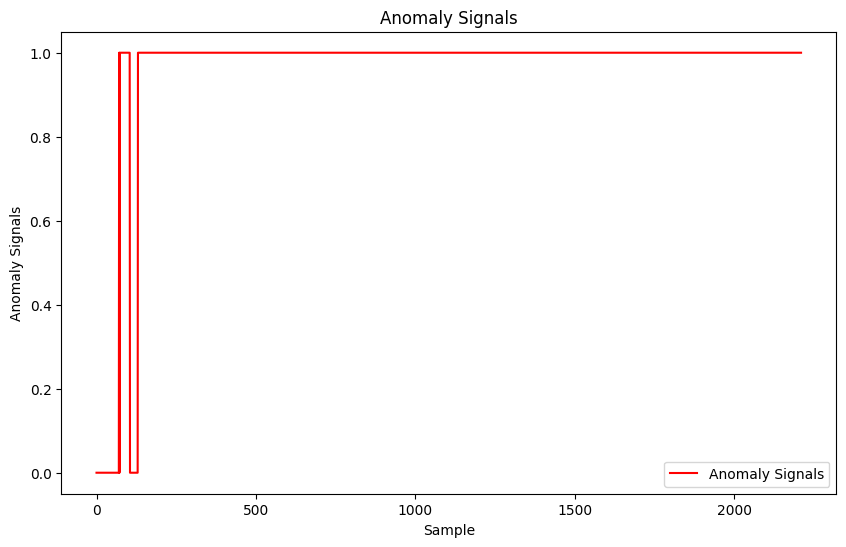

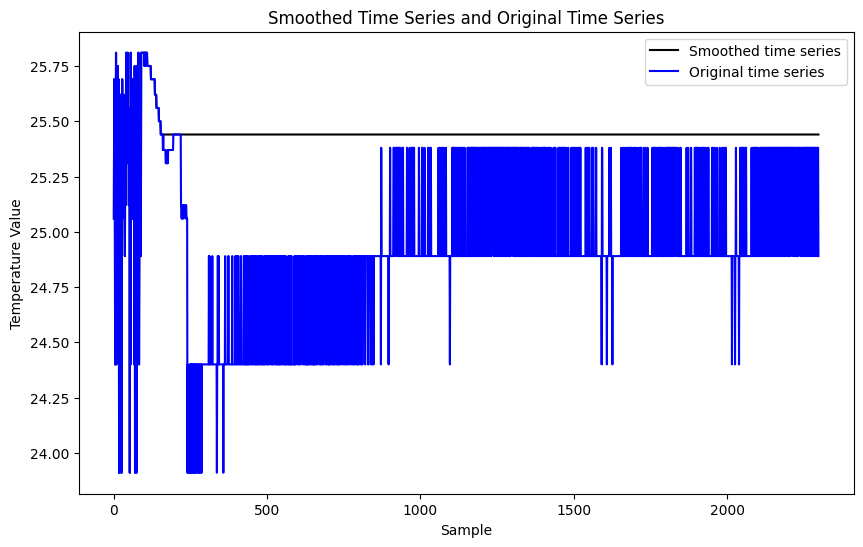

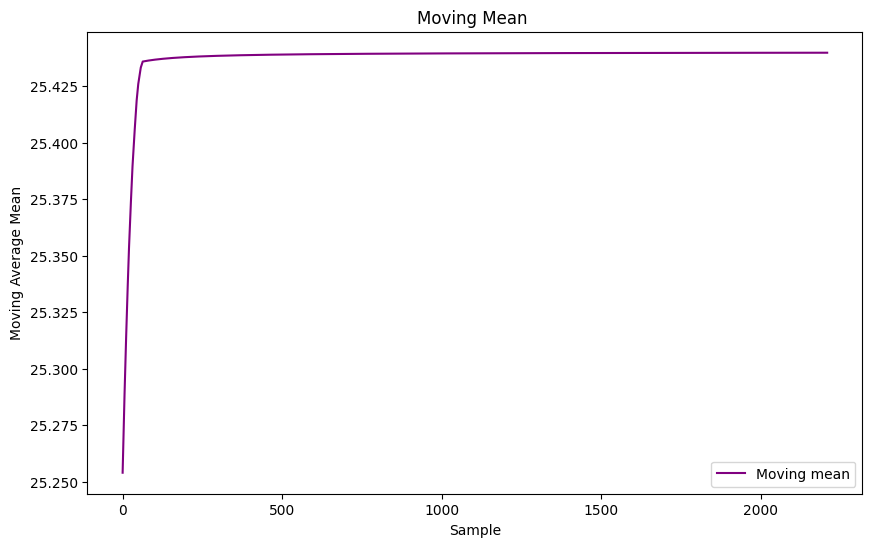

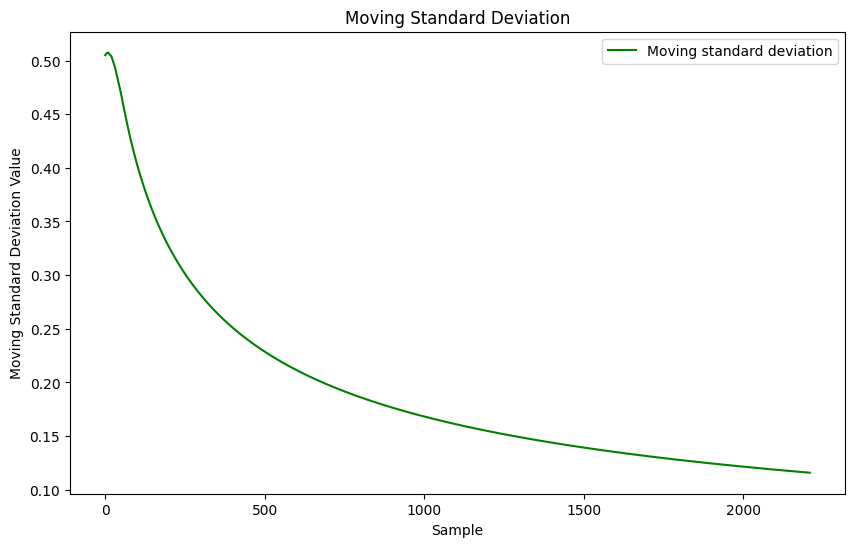

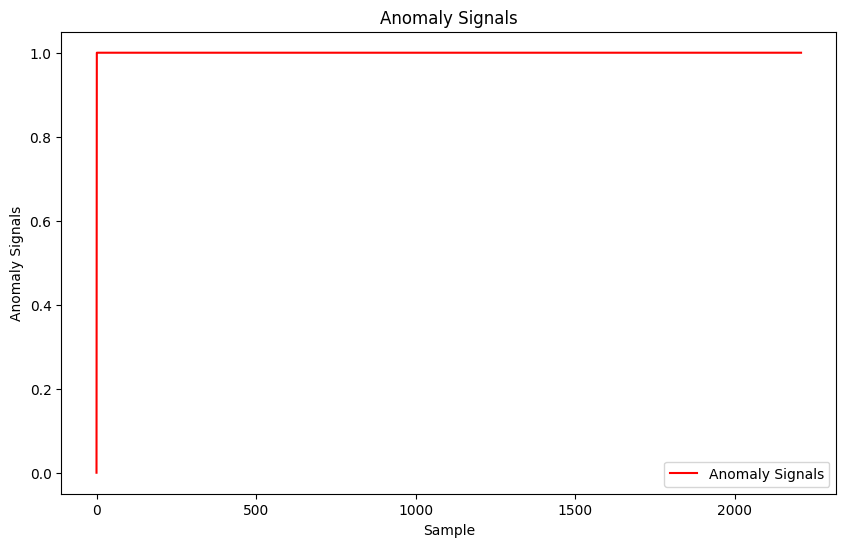

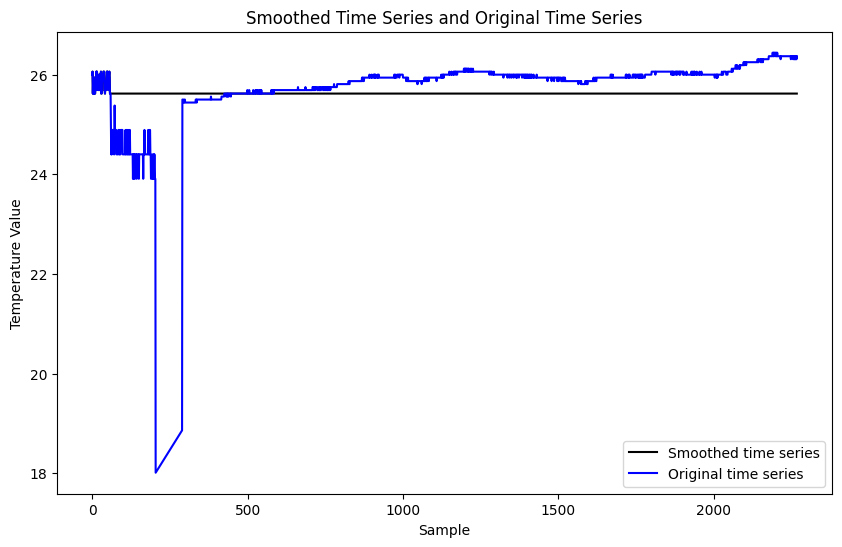

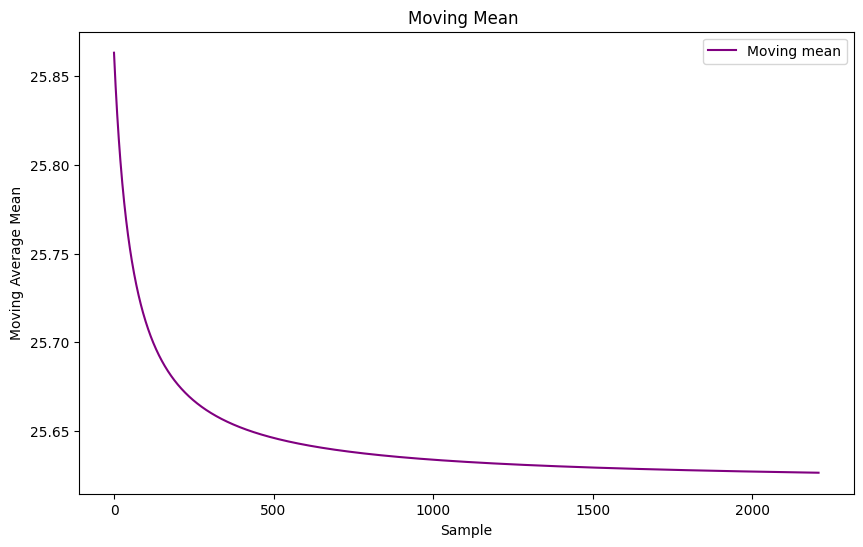

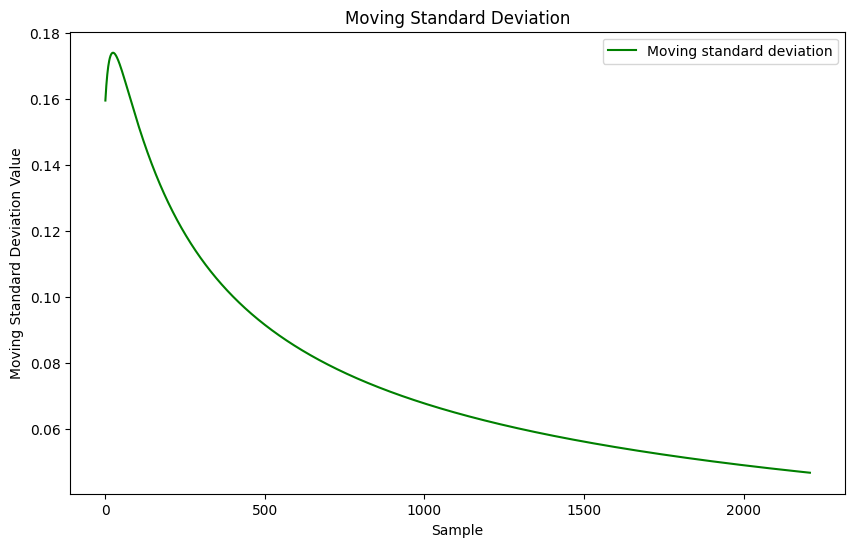

In [7]:
apply_algo('temperature_ds18b20.xlsx',15,6,3)

anomaly_signals,ITS_smoothed, data = apply_algo('temperature_lm35.xlsx',6,10,7)

# Evaluation metrics for the anomaly detection algorithm  


NR is the number of real anomaly points 

AR is abnormal rate

NP is the total number of points

ND is the number of anomaly points detected

ACC is the accuracy 

Accuracy is the ratio of points detected correctly (including anomaly points which were detected as abnormal, and normal points which were not detected as abnormal) to the total number of points.

ACC = NDC / NP where NDC is the number of points detected correctly, NP is the total number of points

In [ ]:
def calculate_metrics(ITS_smoothed,anomaly_signals,data):
    
    # Total number of points
    NP = len(ITS_smoothed)

    # Number of real anomaly points 
    NR = len(data[data['is_anomaly'] != 0])
    
    # Anomaly Rate (AR)
    AR = NR / NP

    # Number of anomaly points detected
    ND = np.count_nonzero(anomaly_signals)
    
    # Number of points not detected correctly
    NDC = abs(ND - NR)

    # Accuracy (ACC)
    ACC = NDC / NP
    
    return {"Anomaly Ratio (AR): " : AR, "Accuracy (ACC): " : ACC, 
            "Total number of points (NP): ":NP, "Number of points not detected correctly ": NDC}


In [ ]:
#data = pd.read_excel('temperature_lm35.xlsx')
#calculate_metrics(ITS_smoothed,anomaly_signals,data)


